<a href="https://colab.research.google.com/github/SophiaHe/covid19_work/blob/master/Kalmar_Filter_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd
#url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
confirmed = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
death = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
recover = pd.read_csv(url, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "Unites States")
death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "Unites States")
recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "Unites States")

In [0]:
confirmed.loc[confirmed['Country/Region'] == 'Canada']

In [0]:
population=pd.read_csv('https://raw.githubusercontent.com/SophiaHe/COVID19/master/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

# merge region
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)

def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)


ts=create_ts(confirmed)
ts_d=create_ts(death)
ts_rec=create_ts(recover)

# Create data for R script
ts_r=ts.reset_index()
ts_r=ts_r.rename(columns = {'index':'date'})
ts_r['date']=pd.to_datetime(ts_r['date'] ,errors ='coerce')
ts_r.to_csv(r'ts_r.csv')

test

In [0]:
t=ts_d.head()
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']
print(temp)

Load back output from R code, conducting Kalmar filter method

In [0]:
p = pd.read_csv('pred_all.csv')

In [0]:
############ Merge R output due to package problem
t=ts_d
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

Update weather info

In [10]:
!pip install pyweatherbit
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 
#api_key = "26141d374d8e49d0a2e1f1254428ce8e"
#api_key ="f206579c74644c4b96a2423cb56a1687"
#api_key ="81a581ac823849f38427fb5081cb8df8"
api_key ="be7aaf4ff7184347aa1ebc2a2db514fe"

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.
##api.get_forecast(lat=lat, lon=lon)

In [0]:
w=pd.DataFrame(columns=['date','region','min','max'])
for i in range (61,len(confirmed)):
  start_date=pd.to_datetime('2020-01-22')
  for j in range (4,confirmed.shape[1]-2):
    jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date.strftime('%Y-%m-%d'),end_date=(start_date+ pd.DateOffset(days=1)).strftime('%Y-%m-%d')).json
    j=json_normalize(j)
    j=j['data']
    max_temp=json_normalize(j['data'])['max_temp'].values[0] # max
    min_temp=json_normalize(j['data'])['min_temp'].values[0]
    try:
      w=w.append({'date':confirmed.columns[j],'region':confirmed.iloc[i,confirmed.shape[1]-1] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
    except Exception:
      w=w.append({'date':confirmed.columns[j],'region':confirmed.iloc[i,confirmed.shape[1]-1] ,'min':None,'max':None}, ignore_index=True)
    start_date=start_date+ pd.DateOffset(days=1)

In [0]:
w=pd.read_csv('https://raw.githubusercontent.com/Rank23/COVID19/master/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')
#w['date']=pd.to_datetime(w['date'],errors ='coerce')

w_forecast=pd.read_csv('https://raw.githubusercontent.com/Rank23/COVID19/master/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

In [0]:
w.date.unique()

In [0]:
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is t.iloc[i-2,1]):
    t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
    t.iloc[i,6]=(t.iloc[i-1,2]/t.iloc[i-2,2]-1)*100
    t.iloc[i,9]=t.iloc[i-1,2]
  if(t.iloc[i,1] is t.iloc[i-4,1]):
    t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
    t.iloc[i,7]=(t.iloc[i-1,2]/t.iloc[i-4,2]-1)*100
  if(t.iloc[i,1] is t.iloc[i-8,1]):
    t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
    t.iloc[i,8]=(t.iloc[i-1,2]/t.iloc[i-8,2]-1)*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)
t['kalman_prediction']=round(t['kalman_prediction'])
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(1)
train['population']=train['population'].astype('int32')
train['infected_rate'] =train['last_day']/train['population']*10000
train=train.merge(w,how='left',on=['date','region'])
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
  if(np.isnan(train.iloc[i,13])):
    if(train.iloc[i,1] is train.iloc[i-1,1]):
      train.iloc[i,13]=train.iloc[i-1,13]
      train.iloc[i,14]=train.iloc[i-1,14]

Kalman 1 day Prediction with Evaluation

In [0]:
# Select region
region='France_France'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
# p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])
print(p.tail())


In [0]:
# Select region
region='Canada_Ontario'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
# p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])
print(p.tail())

In [0]:
t.region.unique()

In [0]:
# Select region
region='Denmark_Denmark'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
# p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])
print(t.tail())
print(p.tail())

**Prepare data for ML models**

Linear Regression Model

In [0]:
!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='8G')
import numpy as np
from sklearn.linear_model import LinearRegression

In [0]:
# Train: < 0317
# Test: >= 0317 & < 0320
train=train.fillna(0) 
train_df=train[train['date']<'2020-03-17']
boots=train_df[train_df['date']>='2020-03-14'] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>='2020-03-14']]*1000,ignore_index=True)
train_df_hubei=train_df[train_df['region']=='China_Hubei']
test=train[train['date']>='2020-03-17']
test=test[test['date']<'2020-03-20']

test.tail()

In [0]:
# Train LR model
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            'last_day', 'kalman_prediction','infected_rate', 'min', 'max'
          ]
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col])
pred2=pd.DataFrame(columns = ["prediction"], data = pred2);
pred2.prediction=pred2.prediction.round(0);
pred2['confirmed']=test['confirmed'].values; 
pred2['date']=test['date'].values; 
pred2['region']=test['region'].values
pred2.head()



In [0]:
# Select region
selection_region = ["Canada_Ontario", 'Canada_Alberta', 'Canada_British Columbia',
       'Canada_Grand Princess', 'Canada_Manitoba', 'Canada_New Brunswick',
       'Canada_Newfoundland and Labrador', 'Canada_Nova Scotia',
       'Canada_Prince Edward Island', 'Canada_Quebec','Canada_Saskatchewan']


pred2['se'] = np.power((pred2['confirmed'] - pred2['prediction']),2)
#pred2.loc[pred2['region'].isin(selection_region)].groupby(['region','date'], as_index=False)['se'].mean()
#pred2.head()

            region          mse       rmse       mae
41  Canada_Ontario  1495.017241  38.665453  8.948276
            date      region  ...  last_day  kalman_prediction
27607 2020-03-16  Zambia_nan  ...         0                0.0
27608 2020-03-17  Zambia_nan  ...         0                0.0
27609 2020-03-18  Zambia_nan  ...         0                0.0
27610 2020-03-19  Zambia_nan  ...         2                1.0
27611 2020-03-20  Zambia_nan  ...         2                2.0

[5 rows x 11 columns]
                    region  confirmed  kalman_prediction
date                                                    
2020-03-16  Canada_Ontario      177.0              104.0
2020-03-17  Canada_Ontario      185.0              162.0
2020-03-18  Canada_Ontario      221.0              199.0
2020-03-19  Canada_Ontario      257.0              239.0
2020-03-20  Canada_Ontario        NaN              280.0


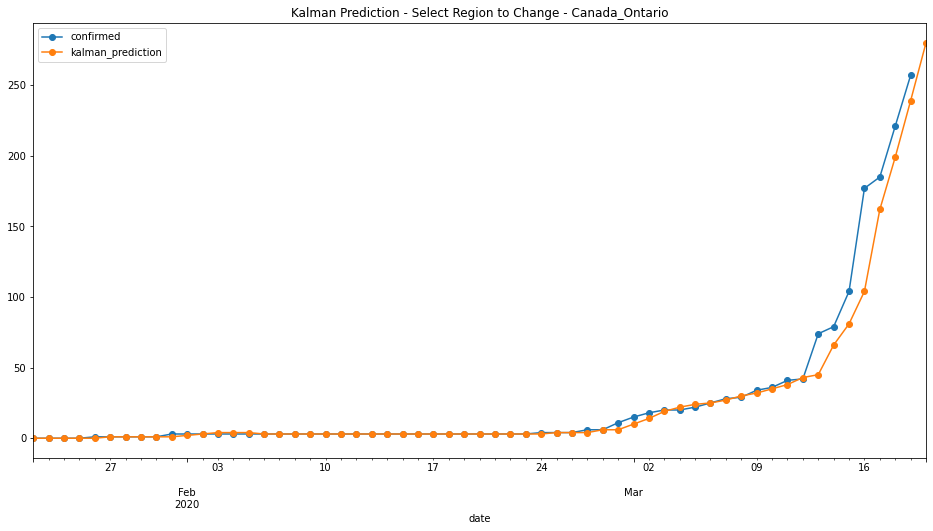

In [110]:
region='Canada_Ontario'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])

place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
# p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])
print(t.tail())
print(p.tail())

long term prediction model

In [119]:
# 30 days from the latest date: april 18 is 30 days after march 19
all_new = pd.read_csv("all_new.csv")

all_new['date']=pd.to_datetime(all_new['date'])
all_new.tail()

,Unnamed: 0,date,Afghanistan_nan,Albania_nan,Algeria_nan,Andorra_nan,Antigua and Barbuda_nan,Argentina_nan,Armenia_nan,Australia_Australian Capital Territory,Australia_From Diamond Princess,Australia_New South Wales,Australia_Northern Territory,Australia_Queensland,Australia_South Australia,Australia_Tasmania,Australia_Victoria,Australia_Western Australia,Austria_nan,Azerbaijan_nan,"Bahamas, The_nan",Bahrain_nan,Bangladesh_nan,Barbados_nan,Belarus_nan,Belgium_nan,Benin_nan,Bhutan_nan,Bolivia_nan,Bosnia and Herzegovina_nan,Brazil_nan,Brunei_nan,Bulgaria_nan,Burkina Faso_nan,Cambodia_nan,Cameroon_nan,Canada_Alberta,Canada_British Columbia,Canada_Grand Princess,Canada_Manitoba,...,"Unites States_Suffolk County, MA","Unites States_Suffolk County, NY","Unites States_Sullivan, TN","Unites States_Summit County, CO","Unites States_Summit, UT","Unites States_Tarrant, TX",Unites States_Tennessee,Unites States_Texas,"Unites States_Thurston, WA","Unites States_Tulsa County, OK","Unites States_Ulster County, NY","Unites States_Umatilla, OR","Unites States_Union, NJ",Unites States_Utah,"Unites States_Ventura, CA",Unites States_Vermont,Unites States_Virgin Islands,Unites States_Virginia,"Unites States_Volusia County, FL","Unites States_Wake County, NC",Unites States_Washington,"Unites States_Washington County, OR","Unites States_Washington, D.C.","Unites States_Washoe County, NV","Unites States_Wayne County, PA","Unites States_Wayne, MI","Unites States_Weber, UT",Unites States_West Virginia,"Unites States_Westchester County, NY","Unites States_Whatcom, WA","Unites States_Williamson County, TN",Unites States_Wisconsin,"Unites States_Worcester, MA",Unites States_Wyoming,"Unites States_Yolo County, CA",Uruguay_nan,Uzbekistan_nan,Venezuela_nan,Vietnam_nan,Zambia_nan
83,84,2020-04-14,59,132,224,217,1,189,341,10,0,957,1,336,118,25,344,137,5548,86,14,542,52,18,101,5449,2,1,34,166,1570,250,247,113,101,38,372,534,22,55,...,0,0,0,0,0,0,493,1015,0,0,0,0,0,290,0,68,3,253,0,0,3804,0,0,0,0,0,0,2,5,0,0,524,0,49,0,265,84,159,268,3
84,85,2020-04-15,62,136,229,227,1,189,341,10,0,957,1,336,118,25,344,141,5548,90,14,542,52,18,104,5449,2,1,34,166,1613,250,249,113,101,39,405,534,22,55,...,0,0,0,0,0,0,494,1015,0,0,0,0,0,290,0,68,3,255,0,0,3804,0,0,0,0,0,0,2,5,0,0,524,0,49,0,274,91,166,281,3
85,86,2020-04-16,62,136,229,227,1,189,354,10,0,964,1,358,118,25,344,144,5806,90,14,542,55,18,104,5621,2,1,36,178,1686,250,261,113,101,39,405,539,22,57,...,0,0,0,0,0,0,497,1015,0,0,0,0,0,312,0,68,3,255,0,0,3804,0,0,0,0,0,0,2,5,0,0,547,0,49,0,274,92,166,281,3
86,87,2020-04-17,67,136,229,247,1,191,372,10,0,964,1,359,122,26,344,144,6000,90,14,564,55,18,104,5621,2,1,37,178,1686,268,261,119,101,39,423,549,22,57,...,0,0,0,0,0,0,518,1015,0,0,0,0,0,329,0,68,3,259,0,0,3957,0,0,0,0,0,0,2,5,0,0,547,0,51,0,274,96,166,286,3
87,88,2020-04-18,69,139,229,247,1,191,392,10,0,1018,1,359,122,26,353,144,6000,90,14,579,58,18,105,5621,2,1,38,189,1686,268,261,119,101,39,426,555,23,57,...,0,0,0,0,0,0,518,1082,0,0,0,0,0,329,0,72,3,259,0,0,3967,0,0,0,0,0,0,2,5,0,0,547,0,51,0,274,96,166,287,3


            Canada_Ontario
date                      
2020-03-19             257
2020-03-20             280
2020-03-21             284
2020-03-22             309
2020-03-23             325
2020-03-24             343
2020-03-25             376
2020-03-26             389
2020-03-27             399
2020-03-28             438
2020-03-29             438
2020-03-30             480
2020-03-31             480
2020-04-01             514
2020-04-02             552
2020-04-03             552
2020-04-04             575
2020-04-05             598
2020-04-06             598
2020-04-07             601
2020-04-08             601
2020-04-09             611
2020-04-10             611
2020-04-11             611
2020-04-12             611
2020-04-13             618
2020-04-14             620
2020-04-15             623
2020-04-16             639
2020-04-17             653
2020-04-18             663


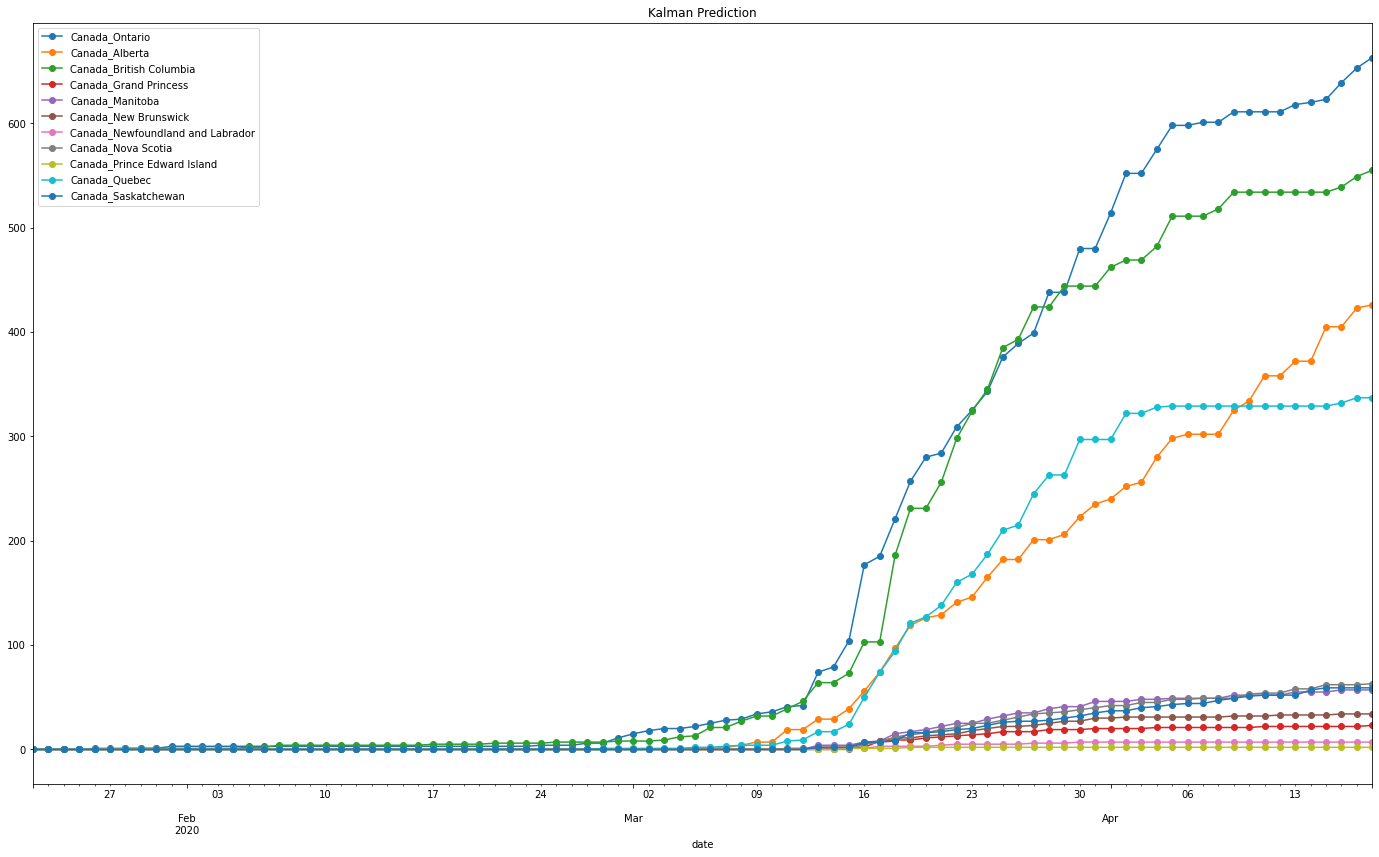

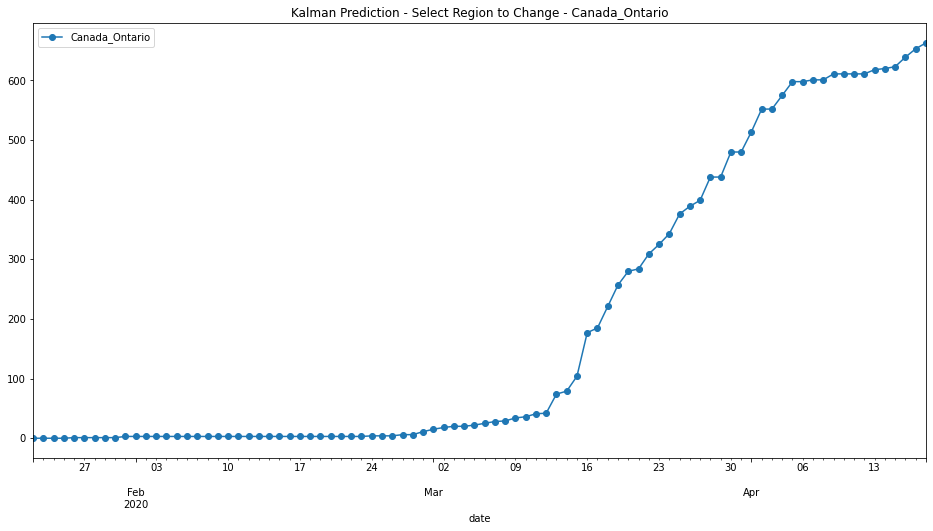

In [126]:
# Select region
region=['date',"Canada_Ontario", 'Canada_Alberta', 'Canada_British Columbia',
       'Canada_Grand Princess', 'Canada_Manitoba', 'Canada_New Brunswick',
       'Canada_Newfoundland and Labrador', 'Canada_Nova Scotia',
       'Canada_Prince Edward Island', 'Canada_Quebec','Canada_Saskatchewan']
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')

p_kalman2=all_new[['date','Canada_Ontario']]
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p_kalman2.columns[0]))
print(p_kalman2.tail(n= 31))